# 🤖🍎 AI Model 🍎🤖
### HackMex 2024 Hackathon
This Notebook was made as part of the 2024 HackMex Hackathon, it's purpose is to calculate the expectated food demand and recommend it both to customers and organizations which are looking to less the amount of food they're wasting.

In [2]:
# Libraries for data manipulation
import pandas as pd
import numpy as np
from collections import Counter

# Libraries for time series forecasting
from prophet import Prophet

# Libraries for date manipulation
from dateutil.relativedelta import relativedelta
import datetime

# Libraries for plotting and visualization
import matplotlib.pyplot as plt

# Library for PDF generation
from fpdf import FPDF

# Miscellaneous libraries
import os

c:\Users\ruyca\Desktop\MealMender-hackMexico\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### 🤖 Functions 🤖

In [63]:
def calculate_frequency(dataframe):
  """
  Calculates the frequency of a given food type using the date stamp and
  consumption data.

  Parameters
  ----------
    dataframe: dataframe containing the date stamp and delta of consumption.
  """
  df = dataframe
  # Shifts df, substracts current period with shifted period
  # calculates the delta.
  df['ds_shifted'] = df['ds'].shift(-1)
  df['delta'] = (df['ds_shifted'] - df['ds']).dt.days
  most_common_interval = df['delta'].mode().iloc[0]

  # Handle different frequencies
  if most_common_interval >= 365:
      freq = 'Y'
  elif most_common_interval >= 30:
      freq = 'M'
  elif most_common_interval >= 7:
      freq = 'W'
  else:
      freq = 'D'

  return freq



def calculate_periods(frequency):
  """
  Returns the approximate most common consumption period (days) according to
  the frequency.

  Parameters
  ----------
    frequency: character indicating how frequent a certain food is consumed.
  """
  if frequency == "Y":
    return 5
  elif frequency == "M":
    return 24
  elif frequency == "W":
    return 48
  elif frequency == "D":
    return 365


  return None


def plot_forecast(m, forecast, closest_forecast, title, save_file):
    """
    Plots the forecast according to the data, prediction and prophet model

    Parameters
    ----------
      m: prophet model
      forecast: predictions
      closest_forecast: closest forecast point to the forecast.
    """
    fig = m.plot(forecast)
    plt.gca().set_title(title, fontsize=16)

    # Highlight the closest forecast point
    plt.scatter(closest_forecast['ds'], closest_forecast['yhat'], color='red', zorder=10)  # Highlight in red

    for _, row in closest_forecast.iterrows():
      plt.annotate(
          f'{row["yhat"]:.2f}',  # Format the forecast value to 2 decimal places
          (row['ds'], row['yhat']),
          textcoords="offset points",  # Position text slightly offset from the point
          xytext=(0,10),  # Distance from text to points (x,y)
          ha='center',  # Horizontal alignment
          fontsize=10,
          color='blue',
          arrowprops=dict(arrowstyle="->", color='blue')  # Arrow pointing to point
      )

        # Get current datetime
    current_datetime = datetime.datetime.now()

    # Format datetime for a filename
    formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # Create a filename with the current date and time
    filename = f"{title}_{formatted_datetime}.jpg"
    if save_file:
      plt.savefig(filename, format='jpg', dpi=300, bbox_inches='tight')
    plt.show()

    # returns filename so it can be included on the PDF report
    return filename


def predict_meat_demand(request_date):
  """
  Predicts the demmand on meat given a specific date

  Parameters
  ---------
    request_date: date to predict consumption for.
  """
  df_path = "datasets\meat_consumptionMX.xlsx"
  df = pd.read_excel(df_path)
  df['ds'] = pd.to_datetime(df['ds'].astype(str), format='%Y')

  freq = calculate_frequency(df)
  periods = calculate_periods(freq)

  m = Prophet()
  m.fit(df)
  future = m.make_future_dataframe(periods=periods, freq=freq)
  forecast = m.predict(future.copy())

  closest_forecast = forecast.iloc[(forecast['ds'] - pd.to_datetime(request_date)).abs().argsort()[:1]]

  return m, closest_forecast, forecast



def predict_avocado_demand(request_date):
  """
  Predicts the demmand on avocado given a specific date

  Parameters
  ---------
    request_date: date to predict consumption for
  """

  df_path = r"datasets\avocado_consumption.xlsx"
  df = pd.read_excel(df_path)
  df['ds'] = pd.to_datetime(df['ds'].astype(str))

  freq = calculate_frequency(df)
  periods = calculate_periods(freq)

  m = Prophet()
  m.fit(df)
  future = m.make_future_dataframe(periods=periods, freq=freq)
  forecast = m.predict(future.copy())

  closest_forecast = forecast.iloc[(forecast['ds'] - pd.to_datetime(request_date)).abs().argsort()[:1]]

  return m, closest_forecast, forecast


def predict_apple_demand(request_date):
  df_path = "datasets\smoothed_apple_consumption.xlsx"
  df = pd.read_excel(df_path)
  df['ds'] = pd.to_datetime(df['ds'].astype(str))

  freq = calculate_frequency(df)
  periods = calculate_periods(freq)

  m = Prophet(
        changepoint_prior_scale=0.05,  # Reduced sensitivity to changepoints
        yearly_seasonality=True
  )
  m.fit(df)
  future = m.make_future_dataframe(periods=periods, freq=freq)
  forecast = m.predict(future.copy())

  closest_forecast = forecast.iloc[(forecast['ds'] - pd.to_datetime(request_date)).abs().argsort()[:1]]

  return m, closest_forecast, forecast


### Report creation

The following code creates a PDF file with more details about a specific prediction

In [64]:
def create_pdf_report(title, units, forecast_value, prediction_date, logo_path, plot_path):
    """
    Create a PDF report with a logo, forecast information, and an embedded plot.

    Args:
    title (str): Title of the prediction.
    units (str): Units of measurement.
    forecast_value (float): The forecast value to report.
    logo_path (str): File path to the application logo.
    plot_path (str): File path to the forecast plot image.
    output_pdf_path (str): File path where the PDF should be saved.
    """
    pdf = FPDF()
    pdf.add_page()

    # Add the logo
    pdf.image(logo_path, x=85, y=8, w=33)  # Centered assuming A4 width

    # Set title and forecast info
    pdf.set_font("Arial", 'B', size=14)
    pdf.ln(40)  # Move down from logo
    pdf.cell(0, 10, txt=title, ln=True, align='C')
    pdf.ln(10)  # Space between title and forecast

    # Set font for forecast value
    pdf.set_font("Arial", size=12)
    pdf.cell(0, 10, txt=f"Forecast: {forecast_value} {units}, for {prediction_date}",
             ln=True, align='C')



    # Ensure there's enough space between the text and the plot
    pdf.ln(10)  # Space between forecast and the plot

    # Add the plot image
    # Adjust y-coordinate considering the spaces added above
    pdf.image(plot_path, x=10, y=80, w=180)  # Adjust y to lower if needed

    # Save the PDF to a file
    output_pdf_path = os.path.join(os.getcwd(), f"forecast_report_{title}.pdf")
    pdf.output(output_pdf_path)



### Implementation example for meat

11:26:28 - cmdstanpy - INFO - Chain [1] start processing
11:26:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\ruyca\Desktop\MealMender-hackMexico\venv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
c:\Users\ruyca\Desktop\MealMender-hackMexico\venv\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\ruyca\Desktop\MealMender-hackMexico\venv\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior

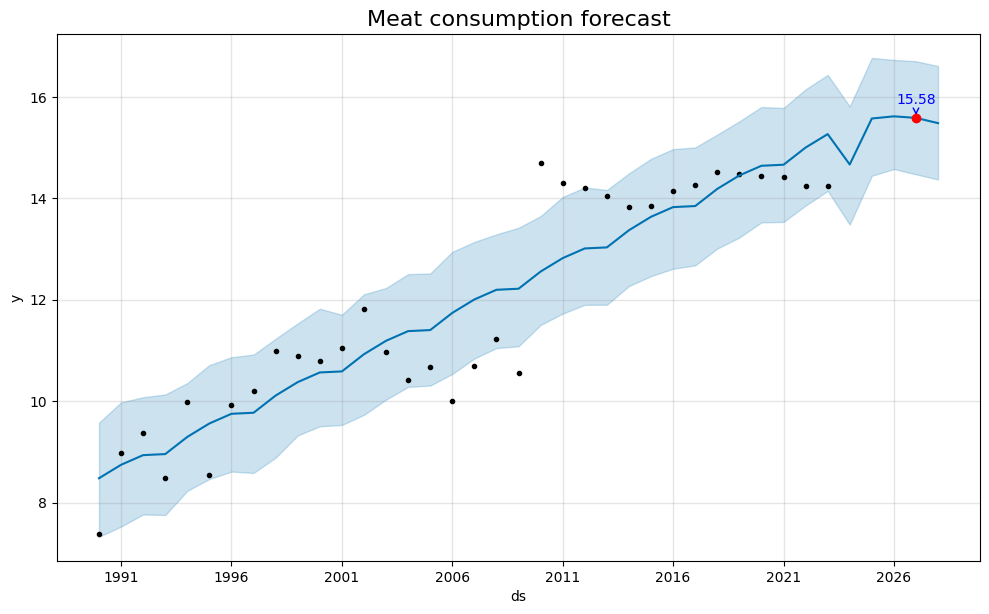

In [65]:
m, result, meat_forecast = predict_meat_demand("2026-12-20")
                # Change last parameter to save the image
plot_filename = plot_forecast(m, meat_forecast, result, "Meat consumption forecast", True)
# Example usage of the function
create_pdf_report(
    title="Meat Consumption Forecast",
    units="Tons",
    forecast_value=round(result["yhat"][37], 2),
    prediction_date = result["ds"][37],
    logo_path="logo.png",
    plot_path=plot_filename
)

### Implementation for avocado

11:26:48 - cmdstanpy - INFO - Chain [1] start processing
11:26:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\ruyca\Desktop\MealMender-hackMexico\venv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
c:\Users\ruyca\Desktop\MealMender-hackMexico\venv\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\ruyca\Desktop\MealMender-hackMexico\venv\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior

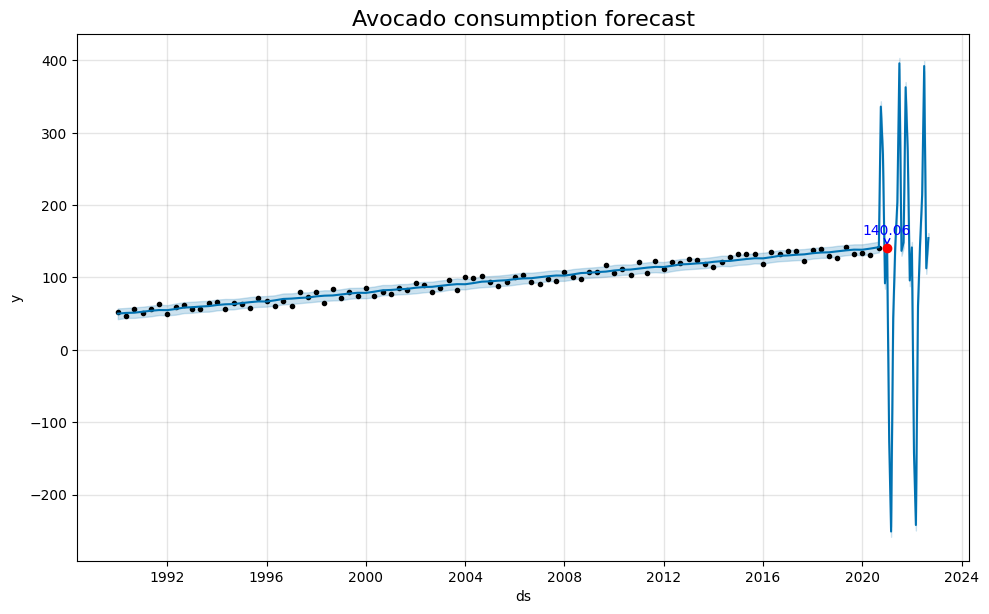

'Avocado consumption forecast_2024-04-14_11-26-48.jpg'

In [66]:
m, result, avocado_forecast = predict_avocado_demand("2021-01-01")
            # Change last parameter to save the image
plot_forecast(m, avocado_forecast, result, "Avocado consumption forecast", True)

### Implementation for apples

11:17:48 - cmdstanpy - INFO - Chain [1] start processing
11:17:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\ruyca\Desktop\MealMender-hackMexico\venv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
c:\Users\ruyca\Desktop\MealMender-hackMexico\venv\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\ruyca\Desktop\MealMender-hackMexico\venv\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior

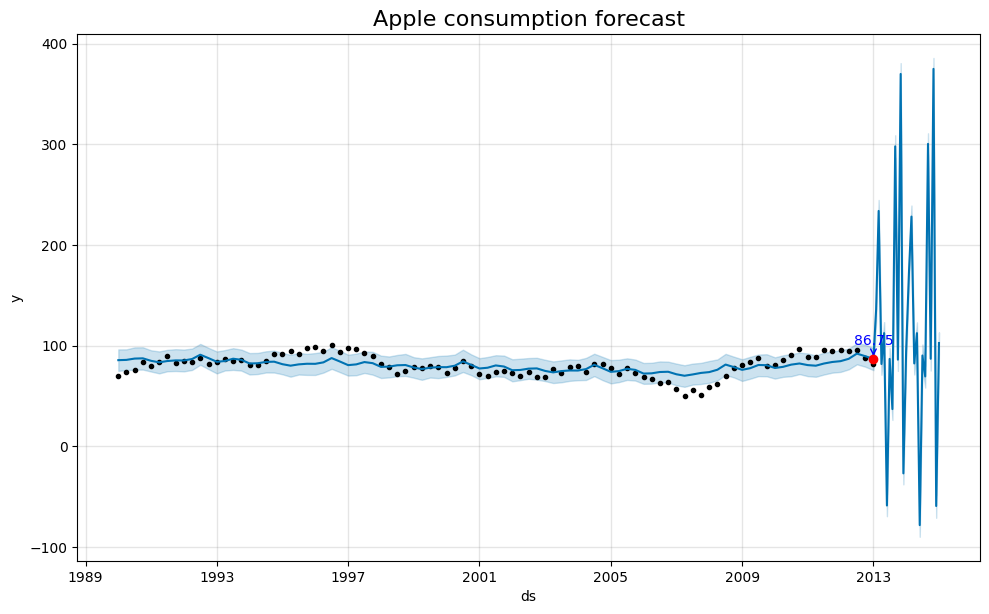

'Apple consumption forecast_2024-04-14_11-17-48.jpg'

In [59]:
m, result, apple_forecast = predict_apple_demand("2013-01-01")

# Change last parameter to save the image
plot_forecast(m, apple_forecast, result, "Apple consumption forecast", True)

---
### 🍅 Waste prediction for tomatoes 🍅

Lowercase food supply column to normalise data

In [34]:
tomatoes_df = pd.read_csv("tomatoes_waste_data.csv")
tomatoes_df["food_supply_stage"] = tomatoes_df["food_supply_stage"].str.lower()

Create functions for prediction

In [37]:
def tomatoes_create_model(polynomial_degree=9, food_supply_stage="whole supply chain"):
  # Set food_supply_stage
  if isinstance(food_supply_stage, str):
    food_supply_stage = food_supply_stage.lower()
  else:
    food_supply_stage="whole supply chain"

  # Filter df to only contain specified supply stage
  filtered_df = tomatoes_df.loc[tomatoes_df["food_supply_stage"] == food_supply_stage]
  x = filtered_df["year"].unique()

  # Calculate average losses for each year
  average_losses = []
  for year in x:
    average_losses.append( filtered_df.loc[ year==filtered_df["year"] ]["loss_percentage"].mean() )
  y = average_losses

  # Create polynomial regression model
  model = np.polyfit(x,y,polynomial_degree)
  return model,x,y


def tomatoes_get_percentage(model,year=datetime.date.today().year):
  percentage = np.polyval(model, year)
  return percentage

def tomatoes_graph(model, x_data, y_data,max_year):
    # Plot original data points
    plt.scatter(x_data, y_data, color='blue', label='Original Data')

    # Generate x values for the plot
    x_values = np.linspace(min(x_data), max_year, 10000)

    # Calculate y values using the polynomial model
    y_values = np.polyval(model, x_values)

    # Plot the polynomial regression curve
    plt.plot(x_values, y_values, color='red', label='Polynomial Fit')

    # Add labels and legend
    plt.xlabel('Year')
    plt.ylabel('Loss Percentage')
    plt.title('Tomatoes Loss Percentage Over Time')
    plt.legend()

    # Show plot
    plt.grid(True)
    plt.show()

Test functions

C:\Users\ruyca\AppData\Local\Temp\ipykernel_47004\2460026571.py:19: RankWarning: Polyfit may be poorly conditioned
  model = np.polyfit(x,y,polynomial_degree)


10.5018310546875


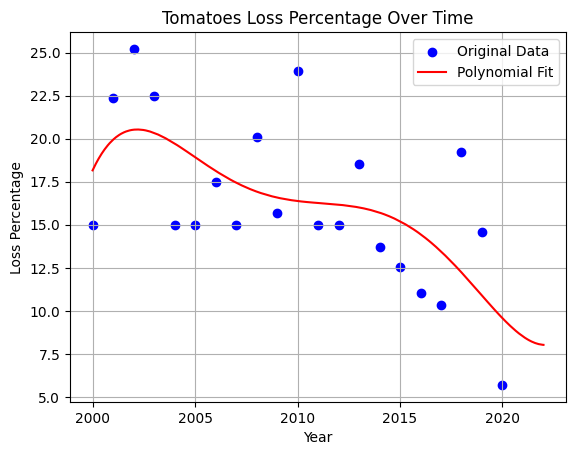

In [38]:
model,x,y = tomatoes_create_model()
print(tomatoes_get_percentage(model,2024))
tomatoes_graph(model,x,y,2022)